In [2]:
import os.path

import numpy as np
import pandas as pd
# ID2024102315041145680199
# 列抽样算法对 acc_sel 的影响，禁用行抽样
from tshpo.lib_class import AnaHelper

_file = AnaHelper.prepare_csv("c05_effect_of_feature_method_v2_original_20241025_0814.csv.gz", return_df=False)
_generate_file = f"{_file}_acc.gz"
if not os.path.exists(_generate_file):
    _odf = pd.read_csv(_file)
    _odf['metric'] = "accuracy"
    _odf.to_csv(_generate_file)
df = pd.concat([
    AnaHelper.load_acc_select(os.path.basename(_file), alpha=0.01),
    AnaHelper.load_acc_select(os.path.basename(_generate_file), alpha=0.01)])
df

,top_n,acc,dataset,metric,fsm,fsr,dsm,dsr,n_exploration,hpo_opt_method
0,1,0,pc4,roc_auc,FastICA,0.1,random,1,30,rs
1,2,0,pc4,roc_auc,FastICA,0.1,random,1,30,rs
2,3,0,pc4,roc_auc,FastICA,0.1,random,1,30,rs
3,4,1,pc4,roc_auc,FastICA,0.1,random,1,30,rs
4,5,1,pc4,roc_auc,FastICA,0.1,random,1,30,rs
...,...,...,...,...,...,...,...,...,...,...
1915,4,1,phoneme,accuracy,SP,0.8,random,1,30,rs
1916,5,1,phoneme,accuracy,SP,0.8,random,1,30,rs
1917,6,1,phoneme,accuracy,SP,0.8,random,1,30,rs
1918,7,1,phoneme,accuracy,SP,0.8,random,1,30,rs


In [3]:
datasets = df['dataset'].drop_duplicates().tolist()
datasets

['pc4',
 'pc3',
 'kc1',
 'ozone-level-8hr',
 'madelon',
 'kr-vs-kp',
 'Bioresponse',
 'sick',
 'spambase',
 'wilt',
 'churn',
 'phoneme']

In [4]:
datasets = df['dataset'].drop_duplicates().tolist()
df = df[df['top_n'] < 7]
adf = df.groupby(by=['top_n', 'metric', 'fsm', 'fsr', 'dsm', 'dsr', 'n_exploration', 'hpo_opt_method'])[
          'acc'].sum() / len(datasets)
adf = adf.reset_index()
adf['metric'] = adf['metric'].apply(lambda x: AnaHelper.normal_metric_name(x))
adf

,top_n,metric,fsm,fsr,dsm,dsr,n_exploration,hpo_opt_method,acc
0,1,Accuracy,FastICA,0.1,random,1,30,rs,0.333333
1,1,Accuracy,FastICA,0.3,random,1,30,rs,0.500000
2,1,Accuracy,FastICA,0.5,random,1,30,rs,0.166667
3,1,Accuracy,FastICA,0.8,random,1,30,rs,0.583333
4,1,Accuracy,MIC,0.1,random,1,30,rs,0.750000
...,...,...,...,...,...,...,...,...,...
235,6,ROC AUC,RF,0.8,random,1,30,rs,1.000000
236,6,ROC AUC,SP,0.1,random,1,30,rs,1.000000
237,6,ROC AUC,SP,0.3,random,1,30,rs,1.000000
238,6,ROC AUC,SP,0.5,random,1,30,rs,1.000000


In [5]:
# 列抽样算法对精度的影响, 固定行抽样为random，行抽样率为0.5
from tshpo.ana_libs import PaperLabel
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns


Saved to /Users/sunwu/SW-Research/AutoML-Benchmark/tshpo/runtime/exp_outputs/effect_fp.pdf


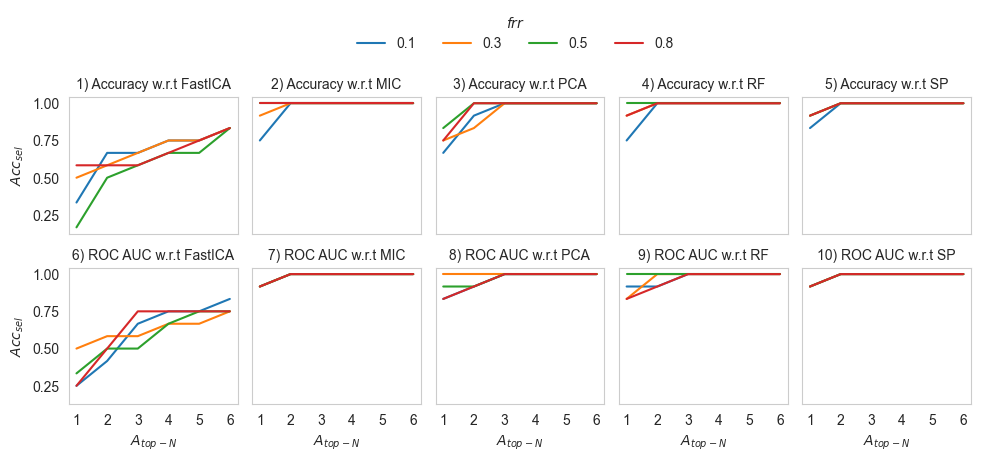

In [6]:
# ID2024112716451617845106
from tshpo.lib_class import FileHelper
# 列抽样算法对精度的影响, 固定行抽样为random，行抽样率为0.3
import numpy as np

_plot_df1 = adf[(adf['metric'] != "f1")
                & (adf['dsr'] == 1)
                & (adf['n_exploration'] == 30)
                & (adf['dsm'] == 'random')]
g = sns.FacetGrid(_plot_df1, col="fsm", row="metric", height=2, aspect=1, despine=False, sharey=True)
g.map_dataframe(sns.lineplot, x='top_n', y='acc', hue='fsr', palette=sns.color_palette())
counter = 0
ax = None
for (metric, fsm), ax in g.axes_dict.items():
    counter += 1
    ax = ax
    # ax.set_title(f"{counter}) {ax.get_title()}")
    ax.set_title(f"{counter}) {metric} w.r.t {fsm}", fontsize=10)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if ax.get_xlabel() != "":
        ax.set_xlabel(PaperLabel.TOP_N_SELECTED_ALGORITHMS)
    if ax.get_ylabel() != "":
        ax.set_ylabel(PaperLabel.ACC_SELECT)
    # ori_ticks=ax.get_xticks()
    # ticks=np.arange(ori_ticks[0],ori_ticks[-1],step=1)
    ax.set_xticks([1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6])
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels, title="$fsr$")
handles, labels = ax.get_legend_handles_labels()
g.add_legend(handles=handles, labels=labels, title="$frr$", loc="upper center", bbox_to_anchor=(0.4, 1.15), ncol=4)
# g.savefig(f"effect_fp.pdf", bbox_inches='tight')
FileHelper().to_pdf(g, f"effect_fp.pdf")

In [7]:
df = pd.read_csv(_file)
df

,Unnamed: 0,id,default_max,default_min,status,#instances,model_training_time,data_processing_time,walk_time,configs_and_metrics,...,max_iteration,model_name,is_trim_sp,n_high_performing_model,n_samples_for_each_model,hpo_opt_method,max_samples,n_exploration,data_sample_method,data_sample_rate
0,0,15c3f4ceeb6801882b54f6e75c674f77,0.8060,0.0994,success,420,177.6935,0.0371,178.52,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
1,0,aac6410d7f7a7450632d7bcda24a4a97,0.7830,0.1955,success,420,202.7460,0.0358,203.67,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
2,0,167b794dd8dc702b40c95f590d80559d,0.7776,0.2543,success,420,108.9078,0.0240,109.46,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
3,0,6f21c6b47bcb9e8d5394082bd165d0e7,0.7083,0.1840,success,420,183.0416,0.0258,183.92,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
4,0,5c05effcddc0aaa8f3bc7e3fb19e61a6,0.8168,0.2040,success,420,144.0489,0.0274,144.77,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,dcf1f35dcf4a2ee28488b1e371f05324,0.7820,0.0391,success,420,404.9115,0.0165,405.77,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
1196,0,d76c57c32a70f848eeb40edcc375106b,0.8069,0.0501,success,420,424.1514,0.0179,424.91,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
1197,0,069c99ca26ceddd032d8f3eb0238e4d1,0.7609,0.0652,success,420,361.1243,0.0108,361.89,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1
1198,0,8575548651acd9f6ce34766dbef32f01,0.7559,0.0584,success,420,361.5308,0.0089,362.13,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,random,1


In [8]:
# ID2024102315051814120402
acc_df = df.groupby(by=['feature_selec_method'])['data_processing_time'].mean() / 60
acc_df.to_latex("fpm_runtime.tex")
acc_df

feature_selec_method
FastICA    0.016819
MIC        0.056245
PCA        0.001374
RF         0.023280
SP         0.000956
Name: data_processing_time, dtype: float64